Found 6563 validated image filenames belonging to 38 classes.
Found 2188 validated image filenames belonging to 38 classes.
Found 10547 validated image filenames belonging to 38 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Pre-trained weights loaded successfully.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


411/411 ━━━━━━━━━━━━━━━━━━━━ 190s 419ms/step - accuracy: 0.2703 - loss: 5.9462 - val_accuracy: 0.6047 - val_loss: 1.4532
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 107s 256ms/step - accuracy: 0.5281 - loss: 2.6621 - val_accuracy: 0.7011 - val_loss: 1.0754
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 103s 248ms/step - accuracy: 0.5961 - loss: 2.2240 - val_accuracy: 0.7290 - val_loss: 0.9599
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 107s 257ms/step - accuracy: 0.6209 - loss: 1.9394 - val_accuracy: 0.7322 - val_loss: 0.9257
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 118s 283ms/step - accuracy: 0.6516 - loss: 1.7491 - val_accuracy: 0.7390 - val_loss: 0.8770
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 114s 273ms/step - accuracy: 0.6556 - loss: 1.6436 - val_accuracy: 0.7633 - val_loss: 0.8132
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 142s 342ms/step - accuracy: 0.6780 - loss: 1.6829 - val_accuracy: 0.7742 - val_loss: 0.7469
Epoch 8/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 107s 258ms/step - accuracy: 0.6823 - loss: 1.46

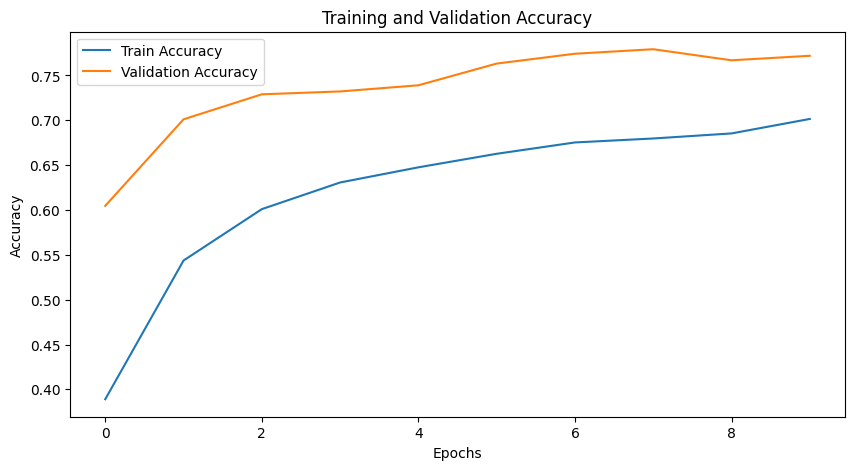

660/660 ━━━━━━━━━━━━━━━━━━━━ 145s 211ms/step


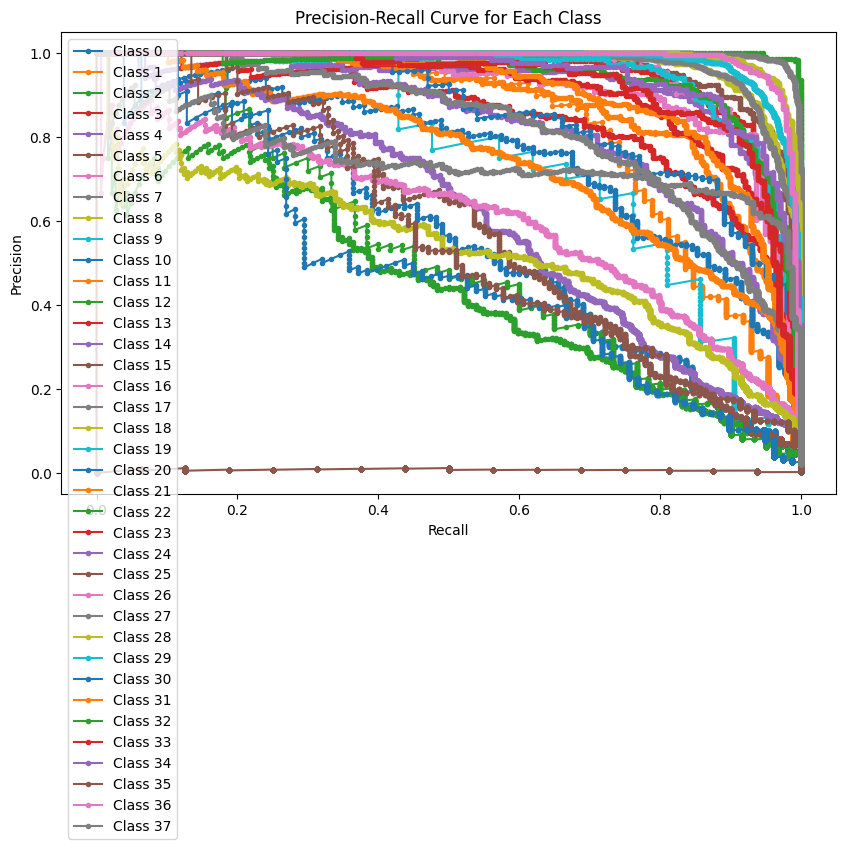

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/plantvillage-dataset/data_distribution_for_SVM"

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

# Collect images and labels from the train folder
train_folder = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split train into 75% training and 25% validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

# Collect images and labels from the test folder (keep as is)
test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=16, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=16, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=16, class_mode="sparse", shuffle=False)

# Define GoogleNet (InceptionV3) model
try:
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    print("Pre-trained weights loaded successfully.")
except:
    base_model = InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 3))
    print("Failed to load pre-trained weights. Training from scratch.")

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(38, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer=SGD(learning_rate=0.0007, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=10, class_weight=class_weight_dict)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
y_true = tf.keras.utils.to_categorical(test_gen.classes, 38)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()